# Notatki

 * Jakbyśmy mieli do czynienia z ciagłym przypływem próbek bez żadnych przerw to moglibyśmy pozwolić sobie na dropnięcie czasu
 * Lepiej celować w wielkość typu 200-400 time steps w LSTM(patrz: [źródło](https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/))

# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

3.7.4


# Załadowanie danych

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


In [3]:
%ls -l data

 Volume in drive D is Data
 Volume Serial Number is 82E7-60C3

 Directory of D:\Studia\Auto_Tag


 Directory of D:\Studia\Auto_Tag\data

13.06.2020  02:25    <DIR>          .
13.06.2020  02:25    <DIR>          ..
04.05.2020  12:59           286˙105 data_real_5s.csv
12.06.2020  23:48        25˙470˙109 data_real_5s_without_step_12_06.csv
12.06.2020  23:49        26˙350˙265 data_real_5s_without_step_12_06_normalized.csv
26.05.2020  07:13        16˙127˙004 data_real_5s_without_step_25_05.csv
08.06.2020  20:00        16˙255˙634 data_real_5s_without_step_25_05_normalized.csv
09.04.2020  16:52         1˙076˙355 easy.csv
09.04.2020  16:52         2˙924˙235 hard.csv
13.06.2020  02:31         1˙355˙379 kaggle.csv
09.04.2020  16:52         2˙787˙990 medium.csv
04.05.2020  14:29         3˙955˙274 rawData.csv
              10 File(s)     96˙588˙350 bytes
               2 Dir(s)  251˙720˙519˙680 bytes free


File Not Found


In [4]:
data_type = '5s_new' # '5s' or '5s_new' or 'raw'

if data_type == 'raw':
    df = pd.read_csv("data//rawData.csv")
    tmp = df.pop('target')
    df['activity'] = tmp
else:
    df = pd.read_csv("data//data_real_5s_without_step_25_05_normalized.csv", index_col = 0)
    tmp = df.pop('activity')
    df['activity'] = tmp
    
df.dropna(inplace=True)



In [5]:
df.head()

,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max,activity
0,0.141273,0.204761,0.341955,0.141973,0.231727,0.188443,0.123579,0.201863,0.222241,0.228852,0.134751,0.337155,cooking
1,0.129883,0.198363,0.341955,0.141973,0.314287,0.340086,0.254777,0.377826,0.206203,0.211486,0.119202,0.337155,cooking
2,0.141269,0.205197,0.341955,0.141973,0.334829,0.341756,0.254777,0.377826,0.182096,0.211651,0.013535,0.287161,cooking
3,0.129458,0.195688,0.341955,0.141973,0.329131,0.343515,0.254777,0.377826,0.162097,0.214452,0.013535,0.221466,cooking
4,0.126727,0.196057,0.341955,0.141973,0.314288,0.345102,0.254777,0.377826,0.148369,0.231137,0.013535,0.221466,cooking


In [6]:
'''
from datetime import datetime

# zmiana timestampów na UNIXowe
timestamps = []

for i in df['timestamp']:
    now = i
    now = datetime.strptime(now, '%Y-%m-%d %H:%M:%S')
    timestamp = datetime.timestamp(now)
    timestamps.append(timestamp)

df['timestamp'] = timestamps
'''

# ciągły czas
if data_type == '5s':
    df.drop(columns = ['timestamp'], inplace = True)

In [7]:
df.head()

,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max,activity
0,0.141273,0.204761,0.341955,0.141973,0.231727,0.188443,0.123579,0.201863,0.222241,0.228852,0.134751,0.337155,cooking
1,0.129883,0.198363,0.341955,0.141973,0.314287,0.340086,0.254777,0.377826,0.206203,0.211486,0.119202,0.337155,cooking
2,0.141269,0.205197,0.341955,0.141973,0.334829,0.341756,0.254777,0.377826,0.182096,0.211651,0.013535,0.287161,cooking
3,0.129458,0.195688,0.341955,0.141973,0.329131,0.343515,0.254777,0.377826,0.162097,0.214452,0.013535,0.221466,cooking
4,0.126727,0.196057,0.341955,0.141973,0.314288,0.345102,0.254777,0.377826,0.148369,0.231137,0.013535,0.221466,cooking


In [8]:
'''
Wygląd danych:

|     Nazwa     | Ilość pól |
| :-----------: | :-------: |
|   timestamp   |     1     |
| accelerometer |     4     |
|   gyroscope   |     4     |
|  magnetometer |     4     |
|    activity   |     1     |


Suma: 14

'''


df.shape

(63812, 13)

# Obróbka danych

In [9]:
'''
Zmiana activity na liczby:

0 - cooking
1 - driving
2 - sitting
3 - sport
4 - walking
'''
df.activity.unique()

array(['cooking', 'driving', 'sitting', 'walking', 'sport'], dtype=object)

In [10]:
df = df.replace({'activity':'cooking'},{'activity':0})
df = df.replace({'activity':'driving'},{'activity':1})
df = df.replace({'activity':'sitting'},{'activity':2})
df = df.replace({'activity':'sport'},{'activity':3})
df = df.replace({'activity':'walking'},{'activity':4})

In [11]:
'''
Podział danych z całego df na X i y:

X - wszystko oprócz activity(time, accelerometer,gyroscope, sound) 
y - activity
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [12]:
df.head()

,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max,activity
0,0.141273,0.204761,0.341955,0.141973,0.231727,0.188443,0.123579,0.201863,0.222241,0.228852,0.134751,0.337155,0
1,0.129883,0.198363,0.341955,0.141973,0.314287,0.340086,0.254777,0.377826,0.206203,0.211486,0.119202,0.337155,0
2,0.141269,0.205197,0.341955,0.141973,0.334829,0.341756,0.254777,0.377826,0.182096,0.211651,0.013535,0.287161,0
3,0.129458,0.195688,0.341955,0.141973,0.329131,0.343515,0.254777,0.377826,0.162097,0.214452,0.013535,0.221466,0
4,0.126727,0.196057,0.341955,0.141973,0.314288,0.345102,0.254777,0.377826,0.148369,0.231137,0.013535,0.221466,0


In [13]:
X.head()

,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max
0,0.141273,0.204761,0.341955,0.141973,0.231727,0.188443,0.123579,0.201863,0.222241,0.228852,0.134751,0.337155
1,0.129883,0.198363,0.341955,0.141973,0.314287,0.340086,0.254777,0.377826,0.206203,0.211486,0.119202,0.337155
2,0.141269,0.205197,0.341955,0.141973,0.334829,0.341756,0.254777,0.377826,0.182096,0.211651,0.013535,0.287161
3,0.129458,0.195688,0.341955,0.141973,0.329131,0.343515,0.254777,0.377826,0.162097,0.214452,0.013535,0.221466
4,0.126727,0.196057,0.341955,0.141973,0.314288,0.345102,0.254777,0.377826,0.148369,0.231137,0.013535,0.221466


In [14]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: activity, dtype: int64

# Podział na dane testowe i treningowe

In [15]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych(4714)
test  - 20% danych(1179)
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

'''
Podział na X_train, y_train, X_test, y_test

X_train, X_test - bez 'activity'
y_train, y_test - sam 'activity' dla X_train, X_test
'''
X_train = train.drop('activity', axis = 1)
y_train = train.activity

X_test = test.drop('activity', axis = 1)
y_test = test.activity

In [16]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 12)
	 y_train: (51049,)
	 X_test: (12763, 12)
	 y_test: (12763,)


In [17]:
# Konwersja danych z pandas dataframe do numpy

df = df.to_numpy()

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [18]:
# Upewnienie się że dane w X_train i X_test są floatem - lepsze dla klasyfikatora

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [19]:
num_classes = 5

# Zamiana wpisu z [1] na [0, 1, 0, 0, 0]
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [20]:
# Upewnienie się że dane w y_train i y_test są floatem - lepsze dla klasyfikatora

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [21]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 12)
	 y_train: (51049, 5)
	 X_test: (12763, 12)
	 y_test: (12763, 5)


# Zmiana wymiarowości

In [22]:
'''
LSTM potrzebuje wymiarów w 3D

Input shape:
 - Samples - jedna sekwwncja to sampel
 - Time steps - punkt obserwacji w próbce
 - Features - jedna obserwacja w punkcie
 
X_train to ~843 próbek, po 1 timestampie w każdej i 13 zmiennych w środku
'''
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 12)
	 y_train: (51049, 5)
	 X_test: (12763, 12)
	 y_test: (12763, 5)


In [23]:
X_train = numpy.expand_dims(X_train, axis=1)
y_train = numpy.expand_dims(y_train, axis=1)

X_test = numpy.expand_dims(X_test, axis=1)
y_test = numpy.expand_dims(y_test, axis=1)

In [24]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 1, 12)
	 y_train: (51049, 1, 5)
	 X_test: (12763, 1, 12)
	 y_test: (12763, 1, 5)


In [25]:
X_train.shape

(51049, 1, 12)

# Funkcję liczące statystyki

In [26]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [27]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [28]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [29]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=False,
                          show_normed=True,
                          class_names=classes)

In [30]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 10
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

# Dobór parametrów

In [31]:
# Wyniki!
grid_result = {
    'activation': 'relu',
    'batch_size': 10,
    'dropout_rate': 0.0,
    'epochs': 100,
    'optimizer': 'Adadelta'
}

# Model

In [32]:
# Stałe do monitorowania pracy modelu zgodne z Grid Searchem

epochs = grid_result['epochs']
batch_size = grid_result['batch_size']
optimizer = grid_result['optimizer']
activation = grid_result['activation']
dropout = grid_result['dropout_rate']
loss_type = 'categorical_crossentropy'
LSTM_size = 128

In [33]:
model = Sequential()
model.add(LSTM(LSTM_size, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            72192     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 5)              645       
Total params: 72,837
Trainable params: 72,837
Non-trainable params: 0
_________________________________________________________________


In [34]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Reshape

'''
W tym wypadku do modelu dodaje linię:
    model.add(Reshape((5, )))
    
By zmienić wynik z one-hot encodera na pojedynczy wynik - GridSearch nie umożliwia, by y było w 3D,
stąd konwersja do 2D
'''
def create_model(optimizer=grid_result['optimizer'], dropout_rate=grid_result['dropout_rate'], activation=grid_result['activation']):
    model = Sequential()
    model.add(LSTM(128, activation=activation, dropout=dropout_rate, return_sequences=True))
    model.add(Dense(5, activation='softmax'))
    model.add(Reshape((5, )))
    model.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy'])
    return model

# Scikit wrapper na Kerasowy klasyfikator
model_wrapper = KerasClassifier(build_fn=create_model, verbose=1)

# Run

In [35]:
from utils.learning_curve import plot_learning_curve

def load_data_target(link):
    df = pd.read_csv(link, index_col = 0)

    df.dropna(inplace=True)
    df.head()
    
    df = df.replace({'target':'Still'},{'target':0})
    df = df.replace({'target':'Car'},{'target':1})
    df = df.replace({'target':'Train'},{'target':2})
    df = df.replace({'target':'Bus'},{'target':3})
    df = df.replace({'target':'Walking'},{'target':4})
    
    X, y = df.iloc[:, 0:-1], df.iloc[:, -1]
    
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
    result = next(kf.split(X, y))

    train = df.iloc[result[0]]
    test =  df.iloc[result[1]]

    X_train = train.drop('target', axis = 1)
    y_train = train.target

    X_test = test.drop('target', axis = 1)
    y_test = test.target
    
    df = df.to_numpy()

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()

    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    num_classes = 5

    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    
    X_train = numpy.expand_dims(X_train, axis=1)
    y_train = numpy.expand_dims(y_train, axis=1)

    X_test = numpy.expand_dims(X_test, axis=1)
    y_test = numpy.expand_dims(y_test, axis=1)
    
    return X_train, y_train, X_test, y_test

def load_data(link, mag=True):
    
    df = pd.read_csv(link, index_col = 0)
    tmp = df.pop('activity')
    df['activity'] = tmp
    
    if not mag:
        df.pop('magnetometer#mean')
        df.pop('magnetometer#std')
        df.pop('magnetometer#min')
        df.pop('magnetometer#max')
        
    if link == 'data//data_real_5s.csv':
        df.drop(columns = ['timestamp'], inplace = True)

    df.dropna(inplace=True)
    df.head()
    
    df = df.replace({'activity':'cooking'},{'activity':0})
    df = df.replace({'activity':'driving'},{'activity':1})
    df = df.replace({'activity':'sitting'},{'activity':2})
    df = df.replace({'activity':'sport'},{'activity':3})
    df = df.replace({'activity':'walking'},{'activity':4})
    
    X, y = df.iloc[:, 0:-1], df.iloc[:, -1]
    
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
    result = next(kf.split(X, y))

    train = df.iloc[result[0]]
    test =  df.iloc[result[1]]

    X_train = train.drop('activity', axis = 1)
    y_train = train.activity

    X_test = test.drop('activity', axis = 1)
    y_test = test.activity
    
    df = df.to_numpy()

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()

    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    num_classes = 5

    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    
    X_train = numpy.expand_dims(X_train, axis=1)
    y_train = numpy.expand_dims(y_train, axis=1)

    X_test = numpy.expand_dims(X_test, axis=1)
    y_test = numpy.expand_dims(y_test, axis=1)
    
    return X_train, y_train, X_test, y_test

def comp(model, X_train, y_train, X_test, y_test, target=False):
    '''
    cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
    cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
    cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
    '''

    EARLY_STOP_PATIENCE = 10
    LEARNING_RATE_PATIENCE = 5

    cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
    cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
    cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

    epochs = grid_result['epochs']
    batch_size = grid_result['batch_size']
    optimizer = grid_result['optimizer']
    activation = grid_result['activation']
    dropout = grid_result['dropout_rate']
    loss_type = 'categorical_crossentropy'
    LSTM_size = 128
    
    model.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(x=X_train,
                        y=y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size, 
                        callbacks=[cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction])

    model.load_weights('best.h5')

    model.save('the_best.h5')
    
    loss, accuracy= model.evaluate(X_test, y_test, verbose=False)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
    ax1.set_xticks(numpy.arange(0, len(history.history['val_loss']), 1))
    ax1.legend(loc='best', shadow=True)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(numpy.arange(0, len(history.history['val_accuracy']), 1))
    ax2.legend(loc='best', shadow=True)
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')


    plt.tight_layout()
    plt.show()

    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

    predictions = model.predict(X_test)
    
    predictions = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x))[1], predictions)))
    predictions = numpy.reshape(predictions, (y_test.shape[0],))

    y_pred = predictions
    
    tmp = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x))[1], y_test)))
    tmp = numpy.reshape(tmp, (y_test.shape[0],))

    y_true = tmp
    
    cm = confusion_matrix(y_true, y_pred)
    
    if target:
        plot_cm(cm, ['still', 'car', 'train', 'bus', 'walking'])
    else:
        plot_cm(cm, ['cooking', 'driving', 'sitting', 'sport', 'walking'])
    
    print(cm)
    
    accuracy, precision, recall, fscore = countStats(y_true, y_pred)
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')
    
    plot_learning_curve(model_wrapper, "LSTM Krzywe uczenia", X_test, numpy.squeeze(y_test, axis=1))
    
def run(link, mag, target=False):
    
    if target:
        X_train, y_train, X_test, y_test = load_data_target(link)
    else:
        X_train, y_train, X_test, y_test = load_data(link, mag)
    
    model = Sequential()
    model.add(LSTM(LSTM_size, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True))
    model.add(Dense(5, activation='softmax'))
    
    comp(model, X_train, y_train, X_test, y_test, target)

# 1 batch danych

Train on 844 samples, validate on 211 samples
Epoch 1/100
844/844 [==============================] - 0s 530us/step - loss: 1.1834 - accuracy: 0.6256 - val_loss: 0.9950 - val_accuracy: 0.6588

Epoch 00001: val_loss improved from inf to 0.99503, saving model to best.h5
Epoch 2/100
844/844 [==============================] - 0s 167us/step - loss: 0.9542 - accuracy: 0.6659 - val_loss: 0.9658 - val_accuracy: 0.6588

Epoch 00002: val_loss improved from 0.99503 to 0.96585, saving model to best.h5
Epoch 3/100
844/844 [==============================] - 0s 162us/step - loss: 0.8966 - accuracy: 0.6765 - val_loss: 0.9268 - val_accuracy: 0.6588

Epoch 00003: val_loss improved from 0.96585 to 0.92683, saving model to best.h5
Epoch 4/100
844/844 [==============================] - 0s 164us/step - loss: 0.8800 - accuracy: 0.6765 - val_loss: 0.8696 - val_accuracy: 0.6682

Epoch 00004: val_loss improved from 0.92683 to 0.86961, saving model to best.h5
Epoch 5/100
844/844 [==============================] -

844/844 [==============================] - 0s 166us/step - loss: 0.7051 - accuracy: 0.7417 - val_loss: 0.7632 - val_accuracy: 0.7204

Epoch 00039: val_loss improved from 0.76338 to 0.76321, saving model to best.h5
Epoch 40/100
844/844 [==============================] - 0s 164us/step - loss: 0.7031 - accuracy: 0.7405 - val_loss: 0.7631 - val_accuracy: 0.7204

Epoch 00040: val_loss improved from 0.76321 to 0.76306, saving model to best.h5
Epoch 41/100
844/844 [==============================] - 0s 173us/step - loss: 0.7017 - accuracy: 0.7370 - val_loss: 0.7625 - val_accuracy: 0.7156

Epoch 00041: val_loss improved from 0.76306 to 0.76251, saving model to best.h5
Epoch 42/100
844/844 [==============================] - 0s 168us/step - loss: 0.7013 - accuracy: 0.7382 - val_loss: 0.7644 - val_accuracy: 0.7299

Epoch 00042: val_loss did not improve from 0.76251
Epoch 43/100
844/844 [==============================] - 0s 173us/step - loss: 0.7005 - accuracy: 0.7488 - val_loss: 0.7669 - val_accur

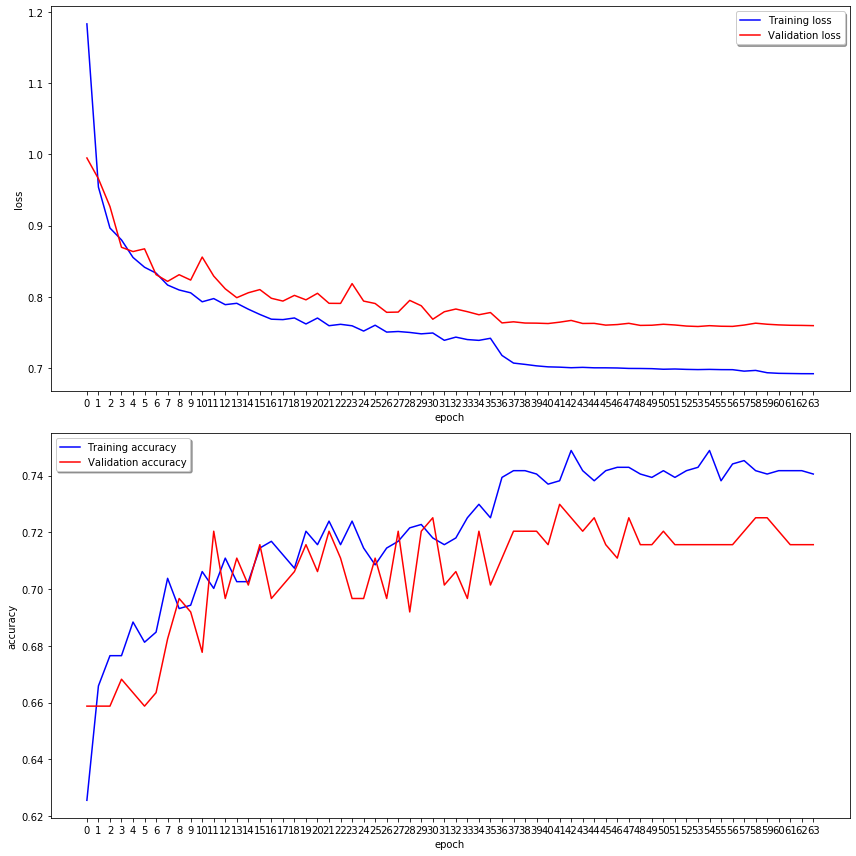

Test loss: 0.758
Test accuracy: 0.716
[[  2   0   3   0   6]
 [  0   8   8   0   1]
 [  0   4 101   0   1]
 [  1   0   0   9  11]
 [  0   1  19   5  31]]
Accuracy: 0.7156398104265402
Precision: 0.7001898703060021
Recall: 0.7156398104265402
F-score: 0.6924655561698452
Epoch 1/1
16/16 [==============================] - 0s 63us/step
Epoch 1/1
54/54 [==============================] - 0s 37us/step
Epoch 1/1
92/92 [==============================] - 0s 22us/step
Epoch 1/1
130/130 [==============================] - 0s 31us/step
Epoch 1/1
168/168 [==============================] - 0s 30us/step
Epoch 1/1
16/16 [==============================] - 0s 62us/step
Epoch 1/1
54/54 [==============================] - 0s 37us/step
Epoch 1/1
92/92 [==============================] - 0s 33us/step
Epoch 1/1
130/130 [==============================] - 0s 31us/step
Epoch 1/1
168/168 [==============================] - 0s 24us/step
Epoch 1/1
16/16 [==============================] - 0s 63us/step
Epoch 1/1
54/54 [===

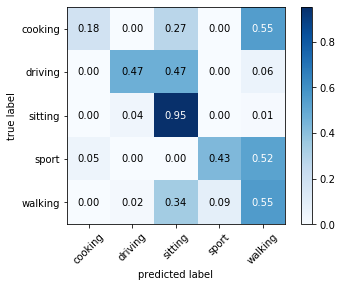

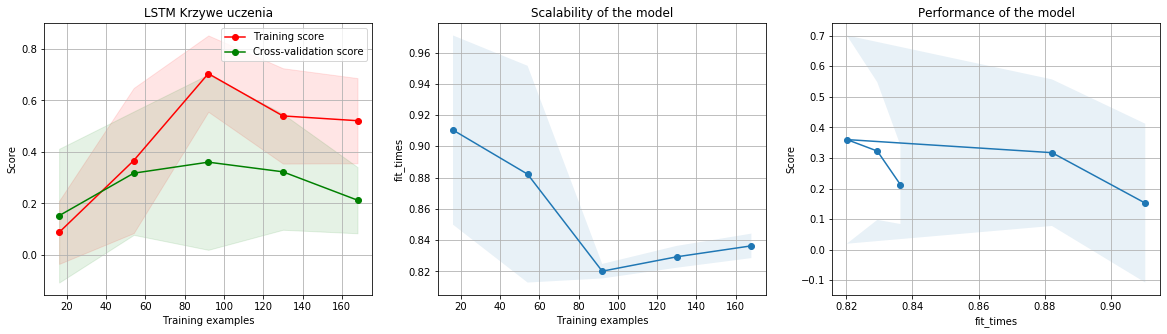

In [36]:
run("data//data_real_5s.csv", True)

# 2 batch danych

Train on 51049 samples, validate on 12763 samples
Epoch 1/100
51049/51049 [==============================] - 9s 176us/step - loss: 0.6002 - accuracy: 0.8014 - val_loss: 0.5654 - val_accuracy: 0.8096

Epoch 00001: val_loss improved from inf to 0.56539, saving model to best.h5
Epoch 2/100
51049/51049 [==============================] - 9s 172us/step - loss: 0.5698 - accuracy: 0.8060 - val_loss: 0.5618 - val_accuracy: 0.8081

Epoch 00002: val_loss improved from 0.56539 to 0.56183, saving model to best.h5
Epoch 3/100
51049/51049 [==============================] - 8s 164us/step - loss: 0.5592 - accuracy: 0.8104 - val_loss: 0.5497 - val_accuracy: 0.8087

Epoch 00003: val_loss improved from 0.56183 to 0.54969, saving model to best.h5
Epoch 4/100
51049/51049 [==============================] - 8s 163us/step - loss: 0.5508 - accuracy: 0.8122 - val_loss: 0.5453 - val_accuracy: 0.8116

Epoch 00004: val_loss improved from 0.54969 to 0.54531, saving model to best.h5
Epoch 5/100
51049/51049 [=========

51049/51049 [==============================] - 9s 168us/step - loss: 0.4903 - accuracy: 0.8284 - val_loss: 0.4957 - val_accuracy: 0.8261

Epoch 00038: val_loss did not improve from 0.49539
Epoch 39/100
51049/51049 [==============================] - 9s 168us/step - loss: 0.4904 - accuracy: 0.8288 - val_loss: 0.4956 - val_accuracy: 0.8262

Epoch 00039: val_loss did not improve from 0.49539
Epoch 40/100
51049/51049 [==============================] - 9s 168us/step - loss: 0.4904 - accuracy: 0.8282 - val_loss: 0.4958 - val_accuracy: 0.8260

Epoch 00040: val_loss did not improve from 0.49539
Epoch 41/100
51049/51049 [==============================] - 9s 167us/step - loss: 0.4906 - accuracy: 0.8287 - val_loss: 0.4959 - val_accuracy: 0.8265

Epoch 00041: val_loss did not improve from 0.49539
Epoch 42/100
51049/51049 [==============================] - 9s 167us/step - loss: 0.4904 - accuracy: 0.8284 - val_loss: 0.4959 - val_accuracy: 0.8260

Epoch 00042: val_loss did not improve from 0.49539

Ep

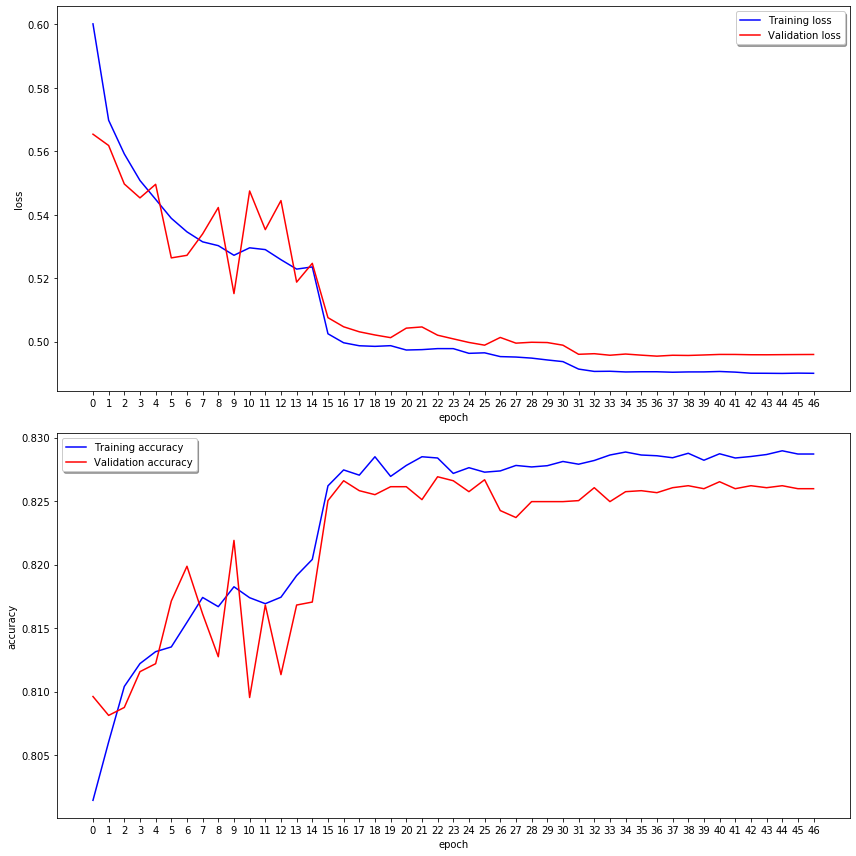

Test loss: 0.495
Test accuracy: 0.826
[[ 337   26  646   25  200]
 [  28   98  114    7   10]
 [ 172   24 7911   12   61]
 [  28    0   18  101  229]
 [ 132    4  416   73 2091]]
Accuracy: 0.8256679464075845
Precision: 0.8019837507306017
Recall: 0.8256679464075845
F-score: 0.8077755176627621
Epoch 1/1
1021/1021 [==============================] - 0s 20us/step
Epoch 1/1
3318/3318 [==============================] - 0s 19us/step
Epoch 1/1
5615/5615 [==============================] - 0s 18us/step
Epoch 1/1
7912/7912 [==============================] - 0s 18us/step
Epoch 1/1
10210/10210 [==============================] - 0s 18us/step
Epoch 1/1
1021/1021 [==============================] - 0s 20us/step
Epoch 1/1
3318/3318 [==============================] - 0s 18us/step
Epoch 1/1
5615/5615 [==============================] - 0s 18us/step
Epoch 1/1
7912/7912 [==============================] - 0s 18us/step
Epoch 1/1
10210/10210 [==============================] - 0s 18us/step
Epoch 1/1
1021/1021 [==

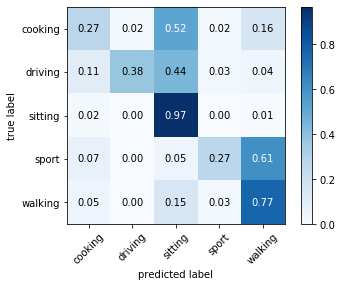

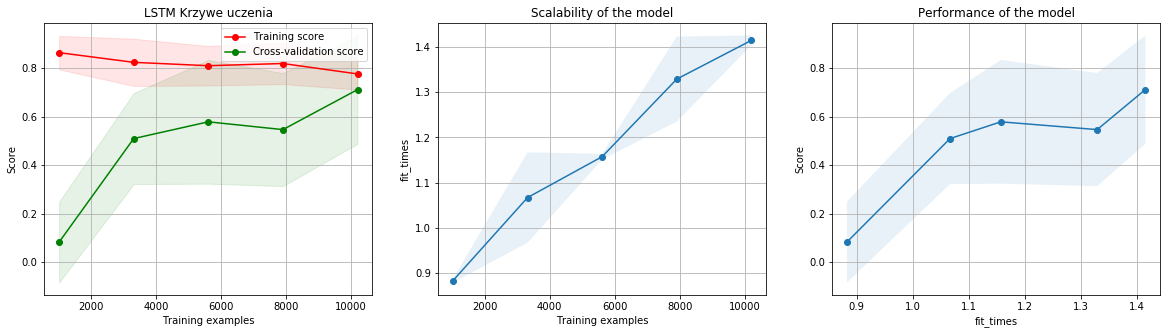

In [37]:
run("data//data_real_5s_without_step_25_05.csv", True)

# 3 batch danych

Train on 51049 samples, validate on 12763 samples
Epoch 1/100
51049/51049 [==============================] - 10s 188us/step - loss: 0.4765 - accuracy: 0.8466 - val_loss: 0.4023 - val_accuracy: 0.8742

Epoch 00001: val_loss improved from inf to 0.40229, saving model to best.h5
Epoch 2/100
51049/51049 [==============================] - 9s 183us/step - loss: 0.3787 - accuracy: 0.8827 - val_loss: 0.3705 - val_accuracy: 0.8861

Epoch 00002: val_loss improved from 0.40229 to 0.37047, saving model to best.h5
Epoch 3/100
51049/51049 [==============================] - 9s 183us/step - loss: 0.3574 - accuracy: 0.8889 - val_loss: 0.3523 - val_accuracy: 0.8880

Epoch 00003: val_loss improved from 0.37047 to 0.35225, saving model to best.h5
Epoch 4/100
51049/51049 [==============================] - 9s 182us/step - loss: 0.3478 - accuracy: 0.8907 - val_loss: 0.3454 - val_accuracy: 0.8913

Epoch 00004: val_loss improved from 0.35225 to 0.34542, saving model to best.h5
Epoch 5/100
51049/51049 [========

51049/51049 [==============================] - 10s 187us/step - loss: 0.2587 - accuracy: 0.9158 - val_loss: 0.2592 - val_accuracy: 0.9162

Epoch 00037: val_loss improved from 0.26123 to 0.25924, saving model to best.h5
Epoch 38/100
51049/51049 [==============================] - 9s 184us/step - loss: 0.2576 - accuracy: 0.9164 - val_loss: 0.2665 - val_accuracy: 0.9152

Epoch 00038: val_loss did not improve from 0.25924
Epoch 39/100
51049/51049 [==============================] - 9s 183us/step - loss: 0.2565 - accuracy: 0.9170 - val_loss: 0.2592 - val_accuracy: 0.9167

Epoch 00039: val_loss improved from 0.25924 to 0.25922, saving model to best.h5
Epoch 40/100
51049/51049 [==============================] - 9s 182us/step - loss: 0.2554 - accuracy: 0.9171 - val_loss: 0.2557 - val_accuracy: 0.9159

Epoch 00040: val_loss improved from 0.25922 to 0.25569, saving model to best.h5
Epoch 41/100
51049/51049 [==============================] - 10s 186us/step - loss: 0.2540 - accuracy: 0.9170 - val_lo

51049/51049 [==============================] - 11s 213us/step - loss: 0.2301 - accuracy: 0.9251 - val_loss: 0.2376 - val_accuracy: 0.9227

Epoch 00075: val_loss did not improve from 0.23713
Epoch 76/100
51049/51049 [==============================] - 11s 216us/step - loss: 0.2301 - accuracy: 0.9253 - val_loss: 0.2370 - val_accuracy: 0.9233

Epoch 00076: val_loss improved from 0.23713 to 0.23697, saving model to best.h5
Epoch 77/100
51049/51049 [==============================] - 11s 206us/step - loss: 0.2300 - accuracy: 0.9255 - val_loss: 0.2369 - val_accuracy: 0.9235

Epoch 00077: val_loss improved from 0.23697 to 0.23687, saving model to best.h5
Epoch 78/100
51049/51049 [==============================] - 10s 204us/step - loss: 0.2297 - accuracy: 0.9254 - val_loss: 0.2371 - val_accuracy: 0.9228

Epoch 00078: val_loss did not improve from 0.23687
Epoch 79/100
51049/51049 [==============================] - 10s 193us/step - loss: 0.2299 - accuracy: 0.9257 - val_loss: 0.2371 - val_accuracy:

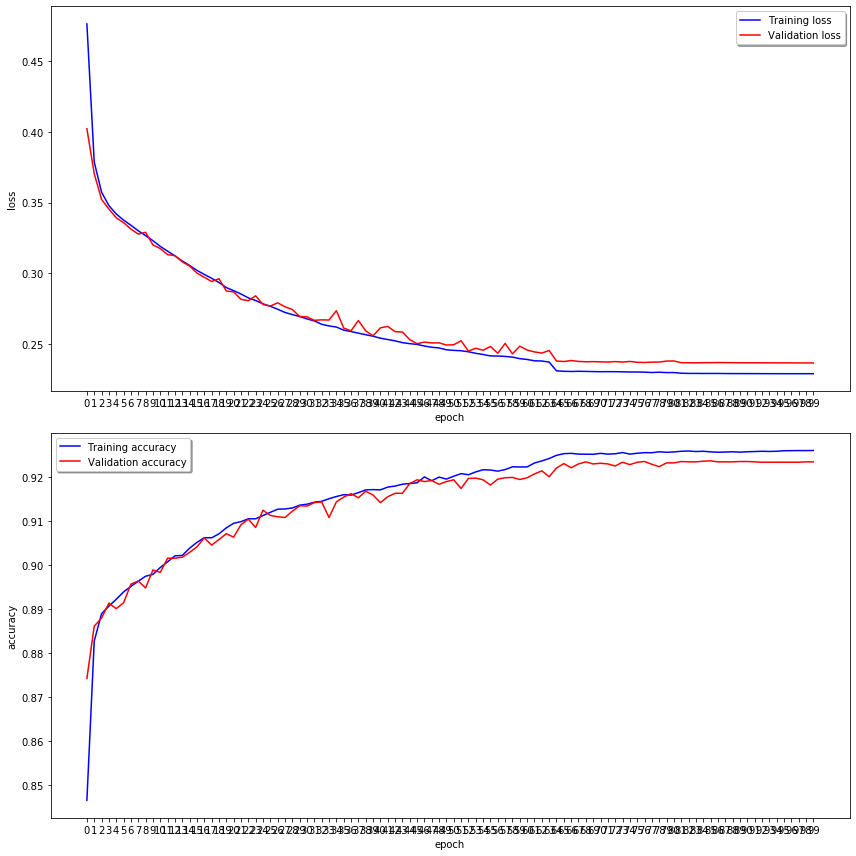

Test loss: 0.237
Test accuracy: 0.923
[[1060    0   80    5   89]
 [   0  175   58    1   23]
 [  68   18 8051    2   41]
 [   5    0   15  300   56]
 [  64    8  409   36 2199]]
Accuracy: 0.9233722479040978
Precision: 0.9222713485808242
Recall: 0.9233722479040978
F-score: 0.9214489448164878
Epoch 1/1
1021/1021 [==============================] - 0s 23us/step
Epoch 1/1
3318/3318 [==============================] - 0s 20us/step
Epoch 1/1
5615/5615 [==============================] - 0s 21us/step
Epoch 1/1
7912/7912 [==============================] - 0s 20us/step
Epoch 1/1
10210/10210 [==============================] - 0s 21us/step
Epoch 1/1
1021/1021 [==============================] - 0s 21us/step
Epoch 1/1
3318/3318 [==============================] - 0s 21us/step
Epoch 1/1
5615/5615 [==============================] - 0s 22us/step
Epoch 1/1
7912/7912 [==============================] - 0s 20us/step
Epoch 1/1
10210/10210 [==============================] - 0s 23us/step
Epoch 1/1
1021/1021 [==

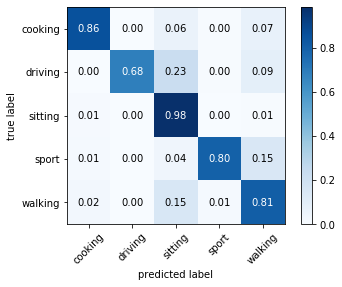

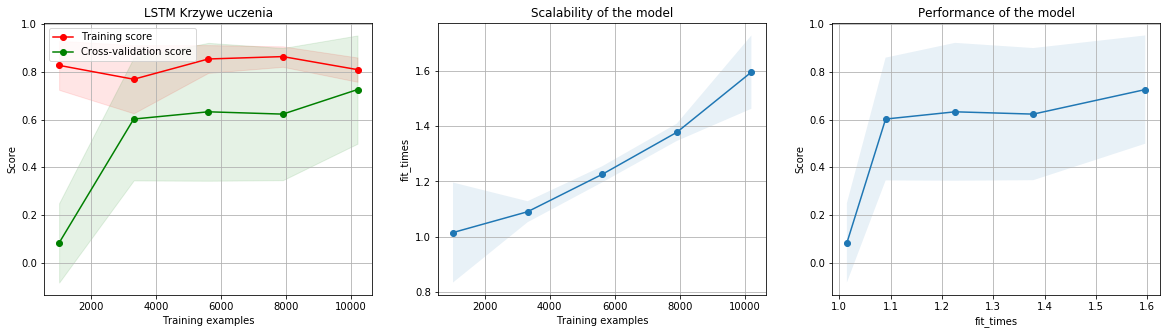

In [38]:
run("data//data_real_5s_without_step_25_05_normalized.csv", True)

# Znormalizowane dane z kaggle

Train on 4714 samples, validate on 1179 samples
Epoch 1/100
4714/4714 [==============================] - 1s 251us/step - loss: 1.3888 - accuracy: 0.4302 - val_loss: 1.1962 - val_accuracy: 0.5089

Epoch 00001: val_loss improved from inf to 1.19625, saving model to best.h5
Epoch 2/100
4714/4714 [==============================] - 1s 184us/step - loss: 1.1906 - accuracy: 0.5231 - val_loss: 1.1404 - val_accuracy: 0.5318

Epoch 00002: val_loss improved from 1.19625 to 1.14043, saving model to best.h5
Epoch 3/100
4714/4714 [==============================] - 1s 185us/step - loss: 1.1585 - accuracy: 0.5390 - val_loss: 1.1160 - val_accuracy: 0.5496

Epoch 00003: val_loss improved from 1.14043 to 1.11596, saving model to best.h5
Epoch 4/100
4714/4714 [==============================] - 1s 185us/step - loss: 1.1381 - accuracy: 0.5558 - val_loss: 1.1142 - val_accuracy: 0.5589

Epoch 00004: val_loss improved from 1.11596 to 1.11416, saving model to best.h5
Epoch 5/100
4714/4714 [=====================

4714/4714 [==============================] - 1s 184us/step - loss: 1.0170 - accuracy: 0.6196 - val_loss: 0.9968 - val_accuracy: 0.6107

Epoch 00038: val_loss did not improve from 0.99618
Epoch 39/100
4714/4714 [==============================] - 1s 184us/step - loss: 1.0169 - accuracy: 0.6173 - val_loss: 0.9968 - val_accuracy: 0.6115

Epoch 00039: val_loss did not improve from 0.99618
Epoch 40/100
4714/4714 [==============================] - 1s 183us/step - loss: 1.0167 - accuracy: 0.6143 - val_loss: 0.9962 - val_accuracy: 0.6132

Epoch 00040: val_loss did not improve from 0.99618
Epoch 41/100
4714/4714 [==============================] - 1s 183us/step - loss: 1.0162 - accuracy: 0.6177 - val_loss: 0.9954 - val_accuracy: 0.6081

Epoch 00041: val_loss improved from 0.99618 to 0.99537, saving model to best.h5
Epoch 42/100
4714/4714 [==============================] - 1s 186us/step - loss: 1.0165 - accuracy: 0.6175 - val_loss: 0.9953 - val_accuracy: 0.6098

Epoch 00042: val_loss improved from

4714/4714 [==============================] - 1s 192us/step - loss: 1.0082 - accuracy: 0.6199 - val_loss: 0.9893 - val_accuracy: 0.6132

Epoch 00076: val_loss did not improve from 0.98926
Epoch 77/100
4714/4714 [==============================] - 1s 196us/step - loss: 1.0081 - accuracy: 0.6190 - val_loss: 0.9890 - val_accuracy: 0.6073

Epoch 00077: val_loss improved from 0.98926 to 0.98904, saving model to best.h5
Epoch 78/100
4714/4714 [==============================] - 1s 201us/step - loss: 1.0079 - accuracy: 0.6173 - val_loss: 0.9887 - val_accuracy: 0.6141

Epoch 00078: val_loss improved from 0.98904 to 0.98871, saving model to best.h5
Epoch 79/100
4714/4714 [==============================] - 1s 211us/step - loss: 1.0073 - accuracy: 0.6230 - val_loss: 0.9897 - val_accuracy: 0.6175

Epoch 00079: val_loss did not improve from 0.98871
Epoch 80/100
4714/4714 [==============================] - 1s 190us/step - loss: 1.0071 - accuracy: 0.6186 - val_loss: 0.9877 - val_accuracy: 0.6158

Epoch 

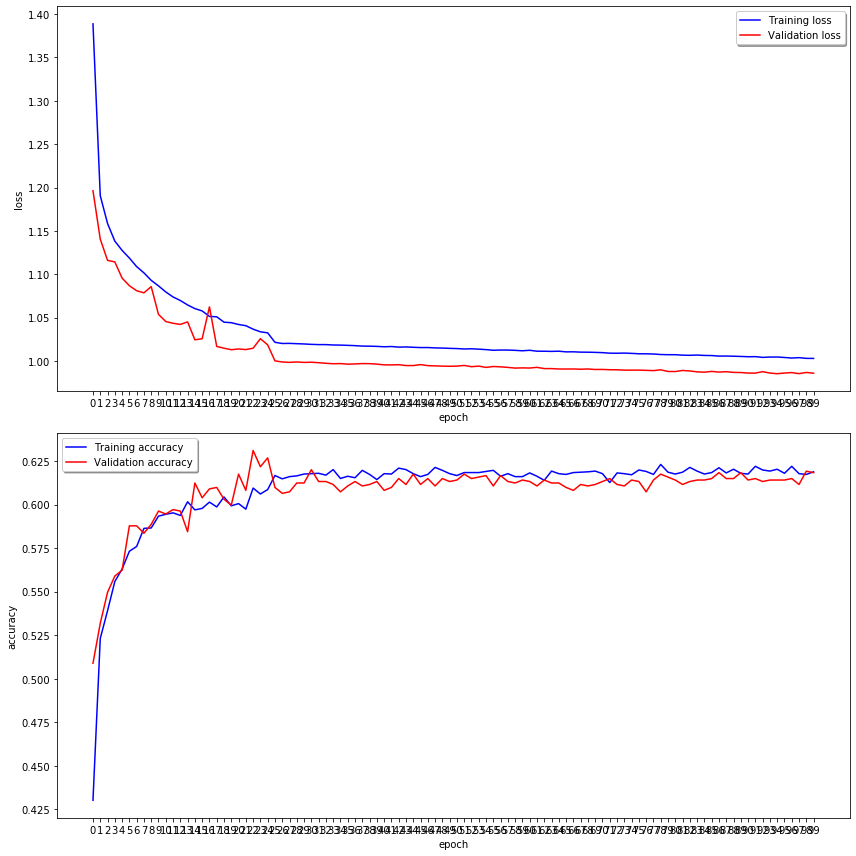

Test loss: 0.985
Test accuracy: 0.614
[[177   4  44   5   6]
 [ 21 107  52  52   4]
 [ 36  24 146  26   4]
 [ 18  43  46 113  16]
 [ 14  18   8  14 181]]
Accuracy: 0.6140797285835454
Precision: 0.6198964274807803
Recall: 0.6140797285835454
F-score: 0.6133934749880708
Epoch 1/1
94/94 [==============================] - 0s 43us/step
Epoch 1/1
306/306 [==============================] - 0s 26us/step
Epoch 1/1
518/518 [==============================] - 0s 25us/step
Epoch 1/1
730/730 [==============================] - 0s 22us/step
Epoch 1/1
943/943 [==============================] - 0s 22us/step
Epoch 1/1
94/94 [==============================] - 0s 43us/step
Epoch 1/1
306/306 [==============================] - 0s 29us/step
Epoch 1/1
518/518 [==============================] - 0s 27us/step
Epoch 1/1
730/730 [==============================] - 0s 23us/step
Epoch 1/1
943/943 [==============================] - 0s 22us/step
Epoch 1/1
94/94 [==============================] - 0s 64us/step
Epoch 1/1
30

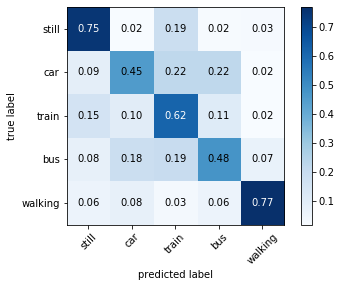

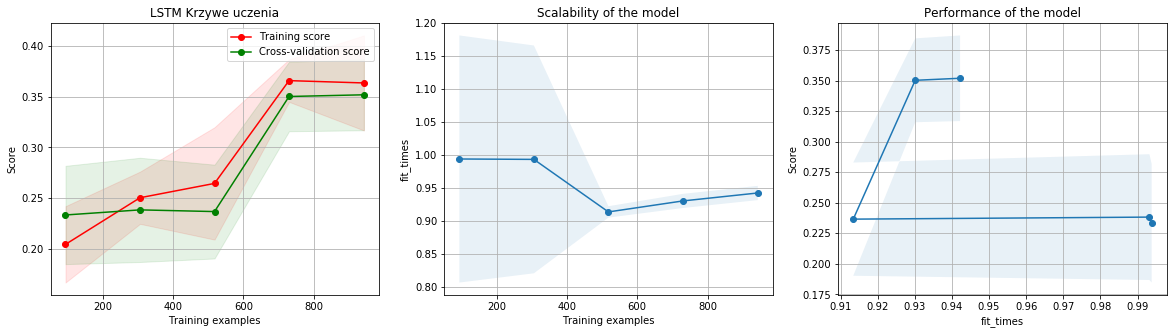

In [39]:
run("data//kaggle.csv", mag=False, target=True)

# Dane z magnetometrem

Train on 84272 samples, validate on 21069 samples
Epoch 1/100
84272/84272 [==============================] - 16s 196us/step - loss: 0.1455 - accuracy: 0.9491 - val_loss: 0.1091 - val_accuracy: 0.9610

Epoch 00001: val_loss improved from inf to 0.10912, saving model to best.h5
Epoch 2/100
84272/84272 [==============================] - 16s 194us/step - loss: 0.0772 - accuracy: 0.9725 - val_loss: 0.0586 - val_accuracy: 0.9801

Epoch 00002: val_loss improved from 0.10912 to 0.05863, saving model to best.h5
Epoch 3/100
84272/84272 [==============================] - 16s 191us/step - loss: 0.0612 - accuracy: 0.9774 - val_loss: 0.0455 - val_accuracy: 0.9849

Epoch 00003: val_loss improved from 0.05863 to 0.04547, saving model to best.h5
Epoch 4/100
84272/84272 [==============================] - 16s 191us/step - loss: 0.0540 - accuracy: 0.9805 - val_loss: 0.0429 - val_accuracy: 0.9854

Epoch 00004: val_loss improved from 0.04547 to 0.04291, saving model to best.h5
Epoch 5/100
84272/84272 [=====

84272/84272 [==============================] - 17s 200us/step - loss: 0.0192 - accuracy: 0.9936 - val_loss: 0.0200 - val_accuracy: 0.9940

Epoch 00038: val_loss did not improve from 0.01987
Epoch 39/100
84272/84272 [==============================] - 17s 197us/step - loss: 0.0192 - accuracy: 0.9935 - val_loss: 0.0200 - val_accuracy: 0.9943

Epoch 00039: val_loss did not improve from 0.01987
Epoch 40/100
84272/84272 [==============================] - 16s 192us/step - loss: 0.0192 - accuracy: 0.9935 - val_loss: 0.0199 - val_accuracy: 0.9944

Epoch 00040: val_loss did not improve from 0.01987
Epoch 41/100
84272/84272 [==============================] - 16s 189us/step - loss: 0.0192 - accuracy: 0.9937 - val_loss: 0.0200 - val_accuracy: 0.9944

Epoch 00041: val_loss did not improve from 0.01987

Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 42/100
84272/84272 [==============================] - 16s 188us/step - loss: 0.0192 - accuracy: 0.9937 - val_loss:

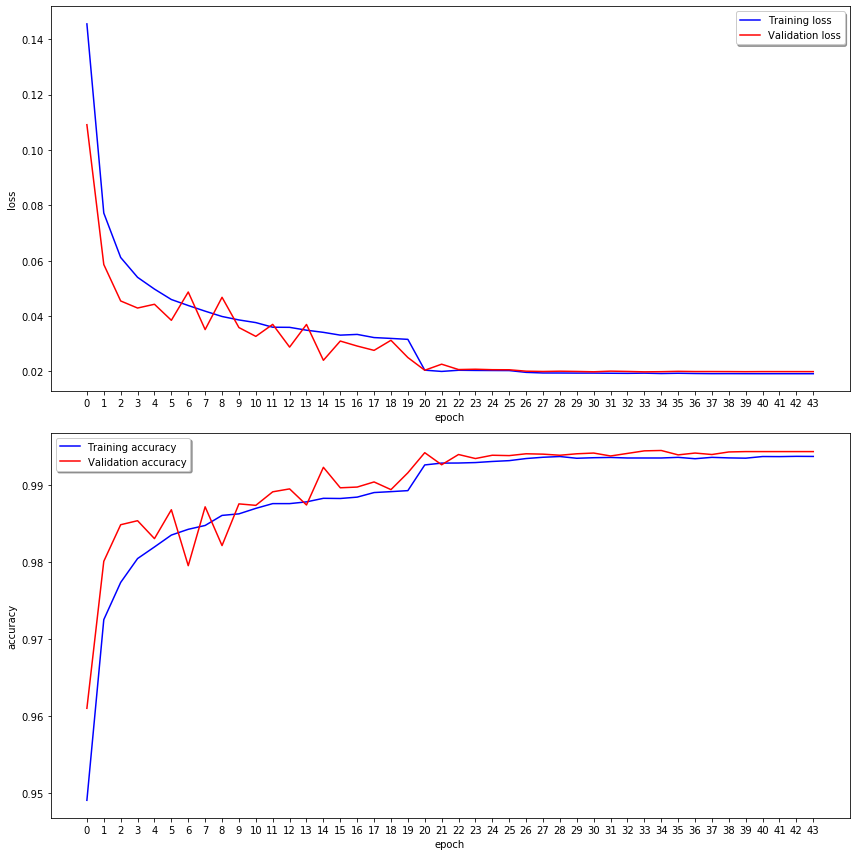

Test loss: 0.0199
Test accuracy: 0.994
[[4939    3   25    0   16]
 [   3 2597    0    0    0]
 [  50    3 5427    0    2]
 [   0    0    0 4725    0]
 [  11    1    1    2 3264]]
Accuracy: 0.9944468175993165
Precision: 0.994453729472423
Recall: 0.9944468175993165
F-score: 0.9944474034543244
Epoch 1/1
1685/1685 [==============================] - 0s 20us/step
Epoch 1/1
5477/5477 [==============================] - 0s 26us/step
Epoch 1/1
9270/9270 [==============================] - 0s 21us/step
Epoch 1/1
13062/13062 [==============================] - 0s 30us/step
Epoch 1/1
16855/16855 [==============================] - 0s 25us/step
Epoch 1/1
1685/1685 [==============================] - 0s 21us/step
Epoch 1/1
5477/5477 [==============================] - 0s 20us/step
Epoch 1/1
9270/9270 [==============================] - ETA:  - 0s 20us/step
Epoch 1/1
13062/13062 [==============================] - 0s 20us/step
Epoch 1/1
16855/16855 [==============================] - 0s 21us/step
Epoch 1/1
1

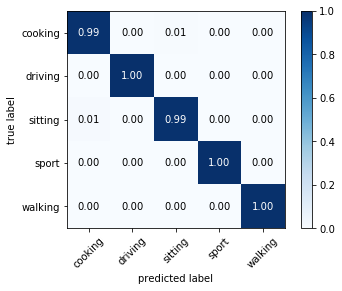

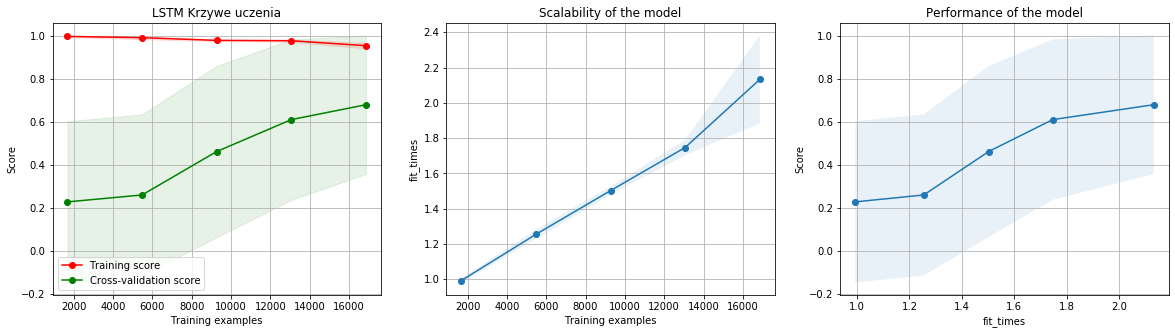

In [40]:
run("data//data_real_5s_without_step_12_06.csv", True)

# Dane bez magnetometru

Train on 84272 samples, validate on 21069 samples
Epoch 1/100
84272/84272 [==============================] - 16s 185us/step - loss: 0.3098 - accuracy: 0.8733 - val_loss: 0.2072 - val_accuracy: 0.9182

Epoch 00001: val_loss improved from inf to 0.20719, saving model to best.h5
Epoch 2/100
84272/84272 [==============================] - 16s 185us/step - loss: 0.1895 - accuracy: 0.9244 - val_loss: 0.2026 - val_accuracy: 0.9172

Epoch 00002: val_loss improved from 0.20719 to 0.20265, saving model to best.h5
Epoch 3/100
84272/84272 [==============================] - 15s 180us/step - loss: 0.1574 - accuracy: 0.9396 - val_loss: 0.1368 - val_accuracy: 0.9506

Epoch 00003: val_loss improved from 0.20265 to 0.13676, saving model to best.h5
Epoch 4/100
84272/84272 [==============================] - 15s 180us/step - loss: 0.1425 - accuracy: 0.9460 - val_loss: 0.1781 - val_accuracy: 0.9309

Epoch 00004: val_loss did not improve from 0.13676
Epoch 5/100
84272/84272 [==============================] - 

84272/84272 [==============================] - 15s 179us/step - loss: 0.0918 - accuracy: 0.9655 - val_loss: 0.0921 - val_accuracy: 0.9660

Epoch 00039: val_loss did not improve from 0.09187

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 40/100
84272/84272 [==============================] - 15s 179us/step - loss: 0.0899 - accuracy: 0.9667 - val_loss: 0.0920 - val_accuracy: 0.9670

Epoch 00040: val_loss did not improve from 0.09187
Epoch 41/100
84272/84272 [==============================] - 15s 178us/step - loss: 0.0899 - accuracy: 0.9666 - val_loss: 0.0916 - val_accuracy: 0.9663

Epoch 00041: val_loss improved from 0.09187 to 0.09155, saving model to best.h5
Epoch 42/100
84272/84272 [==============================] - 17s 200us/step - loss: 0.0899 - accuracy: 0.9663 - val_loss: 0.0916 - val_accuracy: 0.9673

Epoch 00042: val_loss did not improve from 0.09155
Epoch 43/100
84272/84272 [==============================] - 17s 197us/step - loss: 0.0899 - 

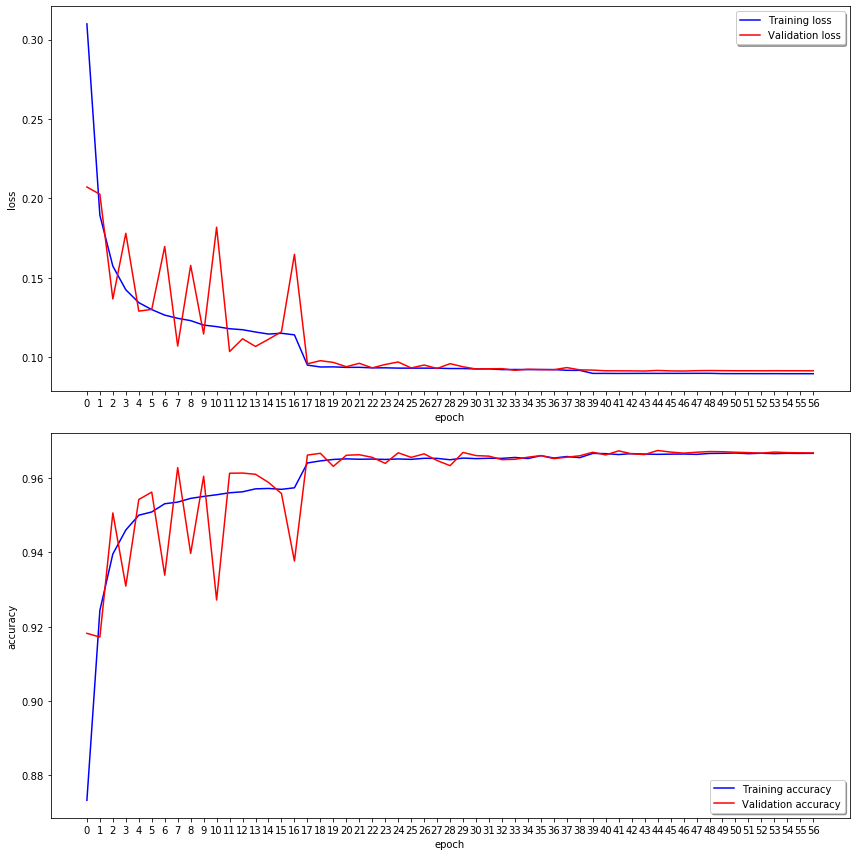

Test loss: 0.0914
Test accuracy: 0.967
[[4732  208   28    0   15]
 [ 277 2298    7    0   18]
 [ 126    9 5347    0    0]
 [   0    0    0 4725    0]
 [  11    1    1    0 3266]]
Accuracy: 0.9667283686933409
Precision: 0.9669833994537878
Recall: 0.9667283686933409
F-score: 0.9667460550751522
Epoch 1/1
1685/1685 [==============================] - 0s 21us/step
Epoch 1/1
5477/5477 [==============================] - 0s 22us/step
Epoch 1/1
9270/9270 [==============================] - 0s 21us/step
Epoch 1/1
13062/13062 [==============================] - 0s 22us/step
Epoch 1/1
16855/16855 [==============================] - 0s 21us/step
Epoch 1/1
1685/1685 [==============================] - 0s 21us/step
Epoch 1/1
5477/5477 [==============================] - 0s 22us/step
Epoch 1/1
9270/9270 [==============================] - 0s 20us/step
Epoch 1/1
13062/13062 [==============================] - 0s 21us/step
Epoch 1/1
16855/16855 [==============================] - 0s 22us/step
Epoch 1/1
1685/168

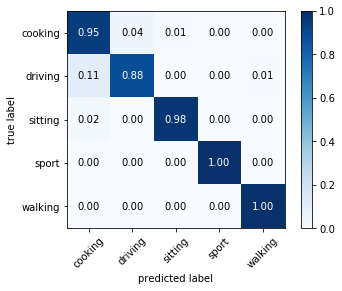

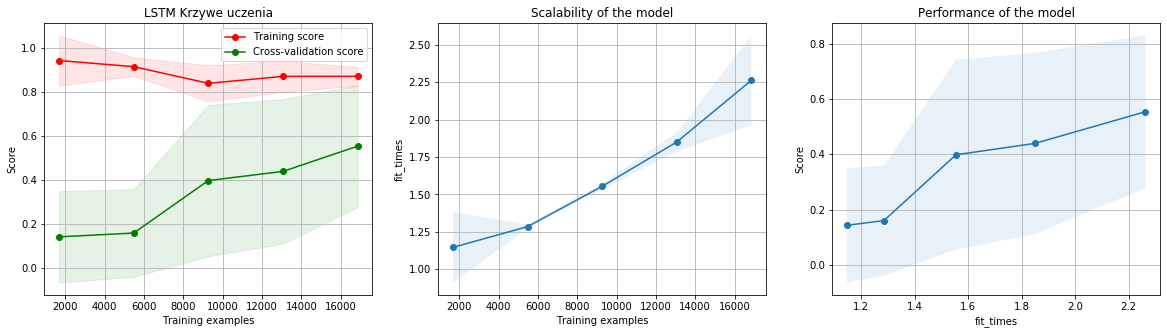

In [41]:
run("data//data_real_5s_without_step_12_06.csv", False)

# Znormalizownae dane z magnetometrem

Train on 84272 samples, validate on 21069 samples
Epoch 1/100
84272/84272 [==============================] - 17s 207us/step - loss: 0.1717 - accuracy: 0.9584 - val_loss: 0.0904 - val_accuracy: 0.9758

Epoch 00001: val_loss improved from inf to 0.09041, saving model to best.h5
Epoch 2/100
84272/84272 [==============================] - 17s 204us/step - loss: 0.0703 - accuracy: 0.9802 - val_loss: 0.0541 - val_accuracy: 0.9821

Epoch 00002: val_loss improved from 0.09041 to 0.05412, saving model to best.h5
Epoch 3/100
84272/84272 [==============================] - 18s 210us/step - loss: 0.0540 - accuracy: 0.9832 - val_loss: 0.0451 - val_accuracy: 0.9839

Epoch 00003: val_loss improved from 0.05412 to 0.04510, saving model to best.h5
Epoch 4/100
84272/84272 [==============================] - 17s 205us/step - loss: 0.0508 - accuracy: 0.9841 - val_loss: 0.0451 - val_accuracy: 0.9851

Epoch 00004: val_loss did not improve from 0.04510
Epoch 5/100
84272/84272 [==============================] - 

84272/84272 [==============================] - 18s 211us/step - loss: 0.0341 - accuracy: 0.9896 - val_loss: 0.0273 - val_accuracy: 0.9905

Epoch 00038: val_loss improved from 0.02821 to 0.02732, saving model to best.h5
Epoch 39/100
84272/84272 [==============================] - 17s 200us/step - loss: 0.0339 - accuracy: 0.9898 - val_loss: 0.0273 - val_accuracy: 0.9906

Epoch 00039: val_loss did not improve from 0.02732
Epoch 40/100
84272/84272 [==============================] - 17s 204us/step - loss: 0.0337 - accuracy: 0.9899 - val_loss: 0.0283 - val_accuracy: 0.9907

Epoch 00040: val_loss did not improve from 0.02732
Epoch 41/100
84272/84272 [==============================] - 17s 203us/step - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.0267 - val_accuracy: 0.9906

Epoch 00041: val_loss improved from 0.02732 to 0.02674, saving model to best.h5
Epoch 42/100
84272/84272 [==============================] - 18s 214us/step - loss: 0.0336 - accuracy: 0.9901 - val_loss: 0.0276 - val_accuracy:

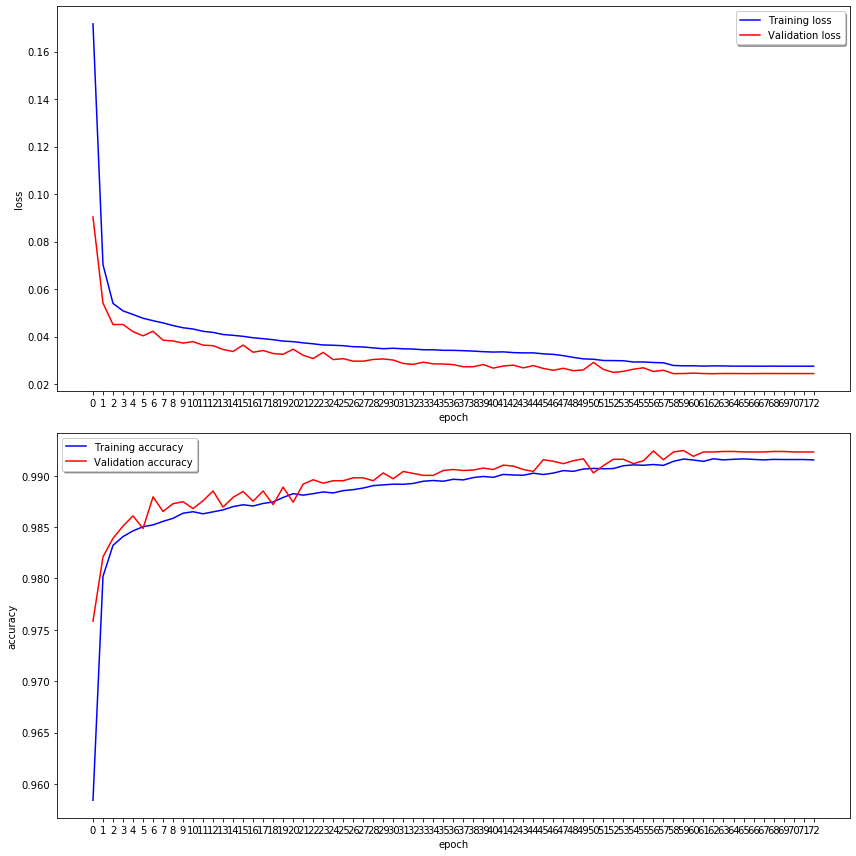

Test loss: 0.0244
Test accuracy: 0.992
[[4925    1   37    0   20]
 [   5 2593    2    0    0]
 [  79    7 5396    0    0]
 [   0    0    0 4725    0]
 [   9    0    2    0 3268]]
Accuracy: 0.9923109782144383
Precision: 0.9923284039832785
Recall: 0.9923109782144383
F-score: 0.9923121746829552
Epoch 1/1
1685/1685 [==============================] - 0s 23us/step
Epoch 1/1
5477/5477 [==============================] - 0s 21us/step
Epoch 1/1
9270/9270 [==============================] - 0s 21us/step
Epoch 1/1
13062/13062 [==============================] - 0s 21us/step
Epoch 1/1
16855/16855 [==============================] - 0s 20us/step
Epoch 1/1
1685/1685 [==============================] - 0s 21us/step
Epoch 1/1
5477/5477 [==============================] - 0s 20us/step
Epoch 1/1
9270/9270 [==============================] - 0s 21us/step
Epoch 1/1
13062/13062 [==============================] - 0s 22us/step
Epoch 1/1
16855/16855 [==============================] - 0s 21us/step
Epoch 1/1
1685/168

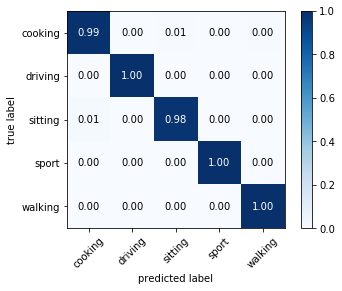

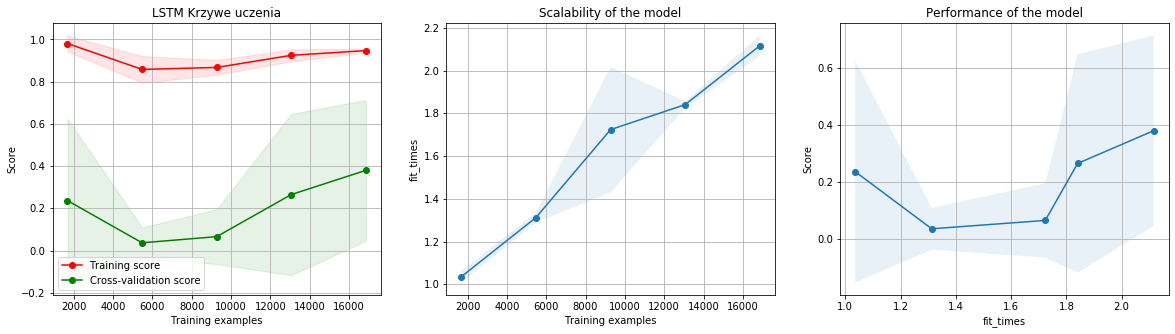

In [42]:
run("data//data_real_5s_without_step_12_06_normalized.csv", True)

# Znormalizownae dane bez magnetometru

Train on 84272 samples, validate on 21069 samples
Epoch 1/100
84272/84272 [==============================] - 17s 207us/step - loss: 0.2988 - accuracy: 0.9133 - val_loss: 0.2001 - val_accuracy: 0.9473

Epoch 00001: val_loss improved from inf to 0.20007, saving model to best.h5
Epoch 2/100
84272/84272 [==============================] - 18s 213us/step - loss: 0.1659 - accuracy: 0.9488 - val_loss: 0.1469 - val_accuracy: 0.9485

Epoch 00002: val_loss improved from 0.20007 to 0.14694, saving model to best.h5
Epoch 3/100
84272/84272 [==============================] - 17s 205us/step - loss: 0.1390 - accuracy: 0.9545 - val_loss: 0.1379 - val_accuracy: 0.9567

Epoch 00003: val_loss improved from 0.14694 to 0.13787, saving model to best.h5
Epoch 4/100
84272/84272 [==============================] - 17s 201us/step - loss: 0.1341 - accuracy: 0.9560 - val_loss: 0.1330 - val_accuracy: 0.9543

Epoch 00004: val_loss improved from 0.13787 to 0.13305, saving model to best.h5
Epoch 5/100
84272/84272 [=====

84272/84272 [==============================] - 17s 200us/step - loss: 0.0983 - accuracy: 0.9644 - val_loss: 0.0994 - val_accuracy: 0.9616

Epoch 00038: val_loss did not improve from 0.09826
Epoch 39/100
84272/84272 [==============================] - 17s 200us/step - loss: 0.0980 - accuracy: 0.9644 - val_loss: 0.0985 - val_accuracy: 0.9623

Epoch 00039: val_loss did not improve from 0.09826
Epoch 40/100
84272/84272 [==============================] - 16s 190us/step - loss: 0.0975 - accuracy: 0.9649 - val_loss: 0.0976 - val_accuracy: 0.9626

Epoch 00040: val_loss improved from 0.09826 to 0.09763, saving model to best.h5
Epoch 41/100
84272/84272 [==============================] - 17s 198us/step - loss: 0.0975 - accuracy: 0.9644 - val_loss: 0.1087 - val_accuracy: 0.9572

Epoch 00041: val_loss did not improve from 0.09763
Epoch 42/100
84272/84272 [==============================] - 17s 197us/step - loss: 0.0973 - accuracy: 0.9646 - val_loss: 0.0963 - val_accuracy: 0.9669

Epoch 00042: val_los

84272/84272 [==============================] - 16s 192us/step - loss: 0.0921 - accuracy: 0.9670 - val_loss: 0.0930 - val_accuracy: 0.9668

Epoch 00075: val_loss improved from 0.09304 to 0.09304, saving model to best.h5
Epoch 76/100
84272/84272 [==============================] - 16s 192us/step - loss: 0.0921 - accuracy: 0.9671 - val_loss: 0.0930 - val_accuracy: 0.9668

Epoch 00076: val_loss improved from 0.09304 to 0.09304, saving model to best.h5
Epoch 77/100
84272/84272 [==============================] - 16s 194us/step - loss: 0.0921 - accuracy: 0.9671 - val_loss: 0.0930 - val_accuracy: 0.9668

Epoch 00077: val_loss improved from 0.09304 to 0.09303, saving model to best.h5
Epoch 78/100
84272/84272 [==============================] - 17s 196us/step - loss: 0.0921 - accuracy: 0.9671 - val_loss: 0.0930 - val_accuracy: 0.9668

Epoch 00078: val_loss improved from 0.09303 to 0.09303, saving model to best.h5
Epoch 79/100
84272/84272 [==============================] - 16s 194us/step - loss: 0.

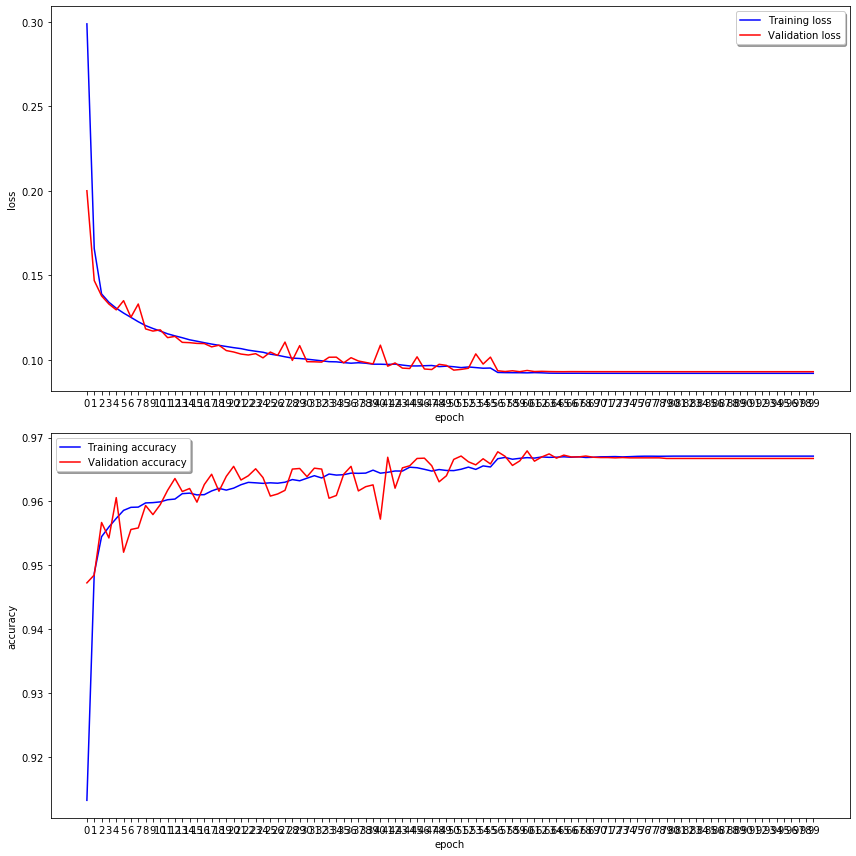

Test loss: 0.093
Test accuracy: 0.967
[[4717  192   56    0   18]
 [ 238 2324   20    0   18]
 [ 115   27 5340    0    0]
 [   0    0    0 4725    0]
 [   9    6    2    0 3262]]
Accuracy: 0.9667283686933409
Precision: 0.9668055698711079
Recall: 0.9667283686933409
F-score: 0.9667257747206576
Epoch 1/1
1685/1685 [==============================] - 0s 27us/step
Epoch 1/1
5477/5477 [==============================] - 0s 24us/step
Epoch 1/1
9270/9270 [==============================] - 0s 25us/step
Epoch 1/1
13062/13062 [==============================] - 0s 21us/step
Epoch 1/1
16855/16855 [==============================] - 0s 21us/step
Epoch 1/1
1685/1685 [==============================] - 0s 23us/step
Epoch 1/1
5477/5477 [==============================] - 0s 21us/step
Epoch 1/1
9270/9270 [==============================] - 0s 22us/step
Epoch 1/1
13062/13062 [==============================] - 0s 23us/step
Epoch 1/1
16855/16855 [==============================] - 0s 22us/step
Epoch 1/1
1685/1685

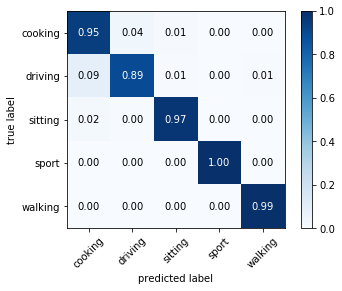

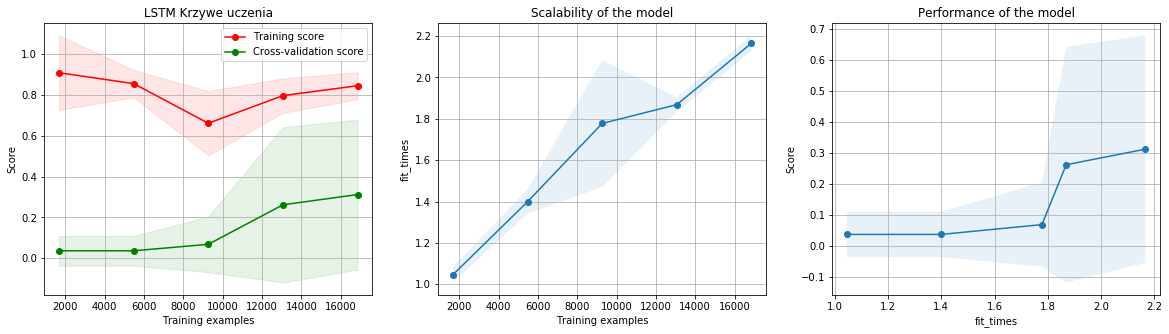

In [43]:
run("data//data_real_5s_without_step_12_06_normalized.csv", False)